# Programming exercise 2: Split-step Fourier method

Due on Monday, 05.11.2018, 14.15h

### Total: 100 points

## Defining the problem

We want to calculate the time evolution of a quantum particle in a on-dimensional potential, i.e. solve the initial value problem

$$ i\partial_t \psi(x,t) = \left[-\frac{1}{2} \partial_{x}^2 + V(x)\right] \psi(x,t) $$

with initial condition

$$ \psi(x,t=0) = \psi_0(x) $$

by representing the wave function $\psi(x,t)$ on a discrete spatial grid and propagating it using the split-step Fourier method.

In [242]:
# load standard libraries

import numpy as np   # standard numerics library

import matplotlib.pyplot as plt   # for making plots

%matplotlib inline

### Exercise 1 (50 points)

Write a function that calculates the discrete Fourier transform of a wave function. Use only even numbers of grid points. You have learned that the spli-step-Fourier method automatically imposes periodic bounbary conditions, so it makes sense to define the spatial grid like -L/2,-L/2+dx ... L/2-dx.

Test your code by Fourier transforming functions where you know what the outcome should be, e.g. a constant function, a cos-function etc.
Implement also the inverse Fourier transform. Make sure you get back the original function after applying the FT twice.

Numpy provides a fast Fourier transform module. Campare your manual FT the result of the fast Fourier algorithm. Pay special attention the ordering in which the Fourier components are retured by the FFT.

Math of the DFT:

We are given a sequence of N numbers {$x_n$}$:=x_0, x_1,\ldots,x_{N-1}$ and transform it into another sequence {$X_k$}$=X_0,\ldots,X_{N-1}$.$$X_k=\sum_{n=0}^{N-1} x_n \cdot \left[ \cos(2\pi kn/N)-i\cdot \sin(2\pi kn/N)\right]$$

In [243]:
#create discrete Fourier transform-function:
#takes an L>0 and 0< #a ∈2ℕ for the length and the number of grid points respectively and returns the discrete
#Fourier Transformation of the array a
def DFT(a,inverse=False): #no need for L
    
    #if L<0:# or N<0:
    #    raise ValueError('The lenght and number of gridpoints needs to be a positive number.')
    if len(a)%2==1:
        raise ValueError('Number of gridpoints needs to be an even number.')
    #define the sign of the exponent:
    s=1 if inverse else -1
    #create grid:
    #x=np.linspace(-L/2,L/2,len(a)) #unnötig
    #dx=L/N
    #result array A
    A=[]
    def transform(k):
        Ak=0
        for i in range(len(a)):
            Ak+=a[i]*np.exp(2j*np.pi*k*i*s/len(a))
        if inverse:
            return Ak/len(a)
        else:
            return Ak
    for i in range(len(a)):
        A.append(transform(i))
    return np.roll(A,-int(len(A)/2)) #rearrange
#inverse DFT outsourced:
def iDFT(A,L,N):
    return DFT(A,L,N,inverse=True)

#### testing
Testing on the box function $$\text{box}=\begin{cases} 1 \text{, for } |x| \leq \frac T2\\0 \text{, else}\end{cases}$$ $$\mathcal F[\text{box}(x)]=\dfrac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \text{box}(t)\ e^{-i\omega t} dt = \dfrac{1}{\sqrt{2\pi}} \int_{-\frac12}^{\frac12}e^{-i\omega t} dt=\dfrac{1}{\sqrt{2\pi}} \dfrac{2 \sin(\omega/2)}{\omega} =\dfrac4{\sqrt{2\pi}} \text{sinc}(\omega /2)$$

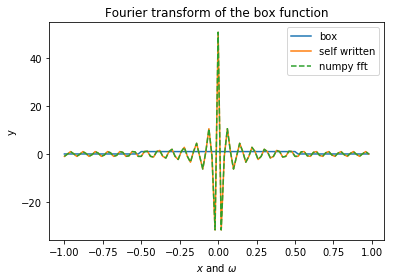

In [244]:
#box function: expected outcome: sinc(x)
grid=100
a=np.linspace(-1,1-2/grid,grid)
def box(x,T,N):
    b=np.zeros(N)
    b[abs(x)<=T]=1
    return b
x=box(a,.5,grid)
plt.plot(a,x,label='box')
plt.plot(a,np.real(DFT(x)),label='self written')
plt.plot(a,np.real(np.fft.fftshift(np.fft.fft(x))),'--',label='numpy fft')
plt.title('Fourier transform of the box function')
plt.xlabel('$x$ and $\omega$')
plt.ylabel('y')
plt.legend()

Our own implementation and the numpy function give the same results. in this case as predicted a sinc function.

### Exercise 2 (50 points)

Implement the split step Fourier algorithm using the numpy FFT and iFFT functions.

Test your code by propagating a Gaussian wave packet in free space. 

Calculate mean and variance at each time and plot them. Does you observation match your expectation?

Animate the time evolution of the wave packet as we did in exercise 5 of programming exercise 1.

Here are some example parameter that you could use:

In [245]:
#defining the gaussian with all parameters
def gaussian(x,mu,sig,p0):
    return 1/np.sqrt(2*np.pi*sig**2)*np.exp(-((x-mu)**2/(2*sig**2)+1j*p0*x))

In [246]:
# define the grid
L = 20
npoints = 256
x=np.linspace(-L/2,L/2-L/npoints,npoints)
dx=np.diff(x).mean()
# parameters of the wave packet
x0 = -5;
sigma = 1;
p0 = 1;

#time steps
dt = 0.1;
tsteps = 50;

#potential 
Vpot=0


In [247]:

from numpy.fft import fft,ifft,fftshift,ifftshift
#define k space
k=fftshift(np.fft.fftfreq(npoints,d=dx))
dk=np.diff(k).mean()
Ekin=k**2/2
#kinetic energy

In [263]:
class wavePacket:
    #initialize wave packet
    def __init__(self,x,x0,sigma,p0,V,Ekin):
        self.x0,self.sigma,self.p0,self.V,self.Ekin=x0,sigma,p0,V,Ekin
        k=fftshift(np.fft.fftfreq(npoints,d=dx))
        dk=np.diff(k).mean()
        #first state
        self.initialstate=gaussian(x,x0,sigma,p0)
        self.xstates=[self.initialstate]
        self.pstates=[]
        #list with all timesteps
        self.tste=[0]
    #time evolution
    def propagate(self,t,dt):
        #first an half step
        self.xstates.append(np.exp(-1j*dt*self.V/2)*self.xstates[0])
        self.pstates.append(fft(self.initialstate))
        self.tste.append(dt/2)
        for time in range(int(t/2)-1):
            #moving in pulse space
            self.pstates.append(np.exp(-1j*self.Ekin*dt)*self.pstates[-1])      
            #transforming back to x space
            self.xstates.append(ifft(self.pstates[-1]))  
            #moving  in x space
            self.xstates.append(np.exp(-1j*dt*self.V)*self.xstates[-1])
            #transforming to pulse
            self.pstates.append(fft(self.xstates[-1]))
            self.tste.append(self.tste[-1]+dt)
            self.tste.append(self.tste[-1]+dt)
        # a last half time step at the end
        self.xstates.append(np.exp(-1j*dt*self.V/2)*self.xstates[-1])
        self.tste.append(self.tste[-1]+dt/2)
        return self.xstates
    def return_nxvector(self,n):
        #gives back the vector at time n
        return self.xstates[n]
    def var_mean(self):
        #calculate the variance and mean at each time step
        means=[]
        var=[]
        for Psi in self.xstates:
            means.append(np.sum(np.conj(Psi)*x*Psi))
            var.append(np.sum(np.conj(Psi)*x**2*Psi)-means[-1])
        return means,var
                     

[0, 0.05, 0.15000000000000002, 0.25, 0.35, 0.44999999999999996, 0.5499999999999999, 0.6499999999999999, 0.7499999999999999, 0.8499999999999999, 0.9499999999999998, 1.0499999999999998, 1.15, 1.25, 1.35, 1.4500000000000002, 1.5500000000000003, 1.6500000000000004, 1.7500000000000004, 1.8500000000000005, 1.9500000000000006, 2.0500000000000007, 2.150000000000001, 2.250000000000001, 2.350000000000001, 2.450000000000001, 2.550000000000001, 2.6500000000000012, 2.7500000000000013, 2.8500000000000014, 2.9500000000000015, 3.0500000000000016, 3.1500000000000017, 3.2500000000000018, 3.350000000000002, 3.450000000000002, 3.550000000000002, 3.650000000000002, 3.750000000000002, 3.8500000000000023, 3.9500000000000024, 4.0500000000000025, 4.150000000000002, 4.250000000000002, 4.350000000000001, 4.450000000000001, 4.550000000000001, 4.65, 4.75, 4.85, 4.8999999999999995]


C:\Users\Tobias\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


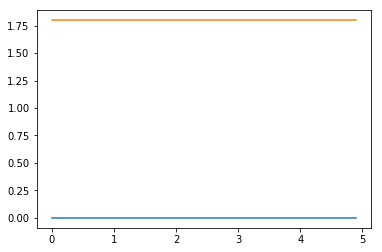

In [266]:

#starting state
x0=0
p0=0
Ekin=0
x=np.linspace(-L/2,L/2,npoints)
#creating our wave Packet
state=wavePacket(x,x0,sigma,p0,Vpot,Ekin)
#moving our package
state.propagate(tsteps,dt)
#calculating the mean and variance of our vector
mean,var=state.var_mean()
#plotting mean and variance at the time steps
plt.plot(state.tste,mean,label="mean")
plt.plot(state.tste,var,label="variance")
#inital=ifft(fftshift(np.roll(fftshift(fft(gaussian(x,x0,sigma))),np.int(np.round(p0/dk)))))
#psi in k space
#Psik=fftshift(fft(initial))

In [ ]:
#animation
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
# add axis specifications
line, = ax.plot([],[],label='Re{$\Psi(x)$}')
linei,=ax.plot([],[],'--',label='Im{$\Psi(x)$}')

plt.ylim(-0.5,0.5)
plt.xlim(-L/2,L/2)
plt.legend()
plt.xlabel('x')
plt.ylabel('Real part of wave function')
plt.title('Propagation of gaussian wave packet in free space')
def animate(t):
    # assign current wave function to y
    # x is gloabaly defined
 #time evolution
    xdata=state.return_nxvector(t)
    line.set_data(x,np.real(xdata))
    linei.set_data(x,np.imag(xdata))
    #plt.legend()
    #plt.text(-9.5,.9,'t=%.1fs'%t,ha='left',va='top',bbox=dict(facecolor='white', alpha=1))
    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,1), # t-values
                               interval=dt*1e4, # wait time before displaying new frame in ms
                               blit=True)

HTML(anim.to_jshtml())

Try out different parameters. What happens if you choose a momentum p0 which is larger than the largest momentum on you momentum space grid?

[[Bonus task (not graded): Compare the results to the exact analytical solution for a propagating wave packet. Try to increase the spatial and temporal step size to see how the error depends on them. You can also look at the wave packet in Fourier space, where the analytical solution is even simpler.]]

Let the wave packet from before evolve in a harmonic potential (with p0=0). Start with a wave packet that is initially at rest but displaced from the ceneter of the hanmonic potential.

Again, calculate temporal evolution of mean and variance and visualize the wave packet evolution in an animation. Is what you observe consistent with your expectation? (A Gaussian wave packet in a harmonic potential is called a coherent state. What did you learn about these in your quantum mechanics lecture?)

In [ ]:
#defining our harmonic oscillator
def harmonic_oscillator(x):
    return 1/2*x**2
L = 20
npoints = 256
x=np.linspace(-L/2,L/2,npoints)
dx=np.diff(x).mean()
# parameters of the wave packet
x0 = -5;
sigma = 1;
p0 = 1;

#time steps
dt = 0.1;
tsteps = 50;

#potential 
Vpot=harmonic_oscillator(x)

In [ ]:
harmonic_wave=wavePacket(x,x0,sigma,p0,Vpot,Ekin)
harmonic_wave.propagate(tsteps,dt)
mean,var=harmonic_wave.var_mean()
plt.plot(t,mean,label="mean")
plt.plot(t,variance,label="variance")

Now simulate the scattering off a potential step $V(x)=\theta(x)$. Choose different initial velocities. Interpret your results. What happens when the reflected wave packet reaches the boundary of the spatial grid?

Example parameters:

In [ ]:
# define the grid
L = 40
npoints = 512
x=np.linspace(-L/2,L/2+40/512,512)
# parameters of the wave packet
x0 = -10;
sigma = 2;
p0 = 1;# try also 1.5 and 2

#time steps
dt = 0.1;
tsteps = 250;

def step(x,T,N):
    b=np.zeros(N)
    b[x>T]=1
    return b
stepfct=step(x,20,512)


stepwave=wavePacket(x,x0,sigma,p0,stepfct,Ekin)
stepwave.propagate(tsteps,dt)
mean,var=stepwave.var_mean()
plt.plot(t,mean,label="mean")
plt.plot(t,variance,label="variance")

[[Bonus question: Be creative! Let your wave packet propagate through a potential barrier, across a well, or down a step etc. Measure the reflected and transitted pobability (and the probability to be inside the barrier) as a function of time and study the transmission systematically as a function of the initial momentum...]]